In [97]:
import math, random
import csv, time

import networkx as nx
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

In [2]:
class Stochastic:
    """" Stochastic variable """

    def __init__(self, law=0, location=0, scale=1, shape=0):
        # distribution law
        self.law = law
        # location parameter
        self.location = location
        # scale parameter
        self.scale = scale
        # form parameter
        self.shape = shape

    def value(self):
        """" Returns the generated value """
        if self.law == 0:
            # rectangular distribution
            return random.uniform(self.location, self.location + self.scale)
        elif self.law == 1:
            # normal distribution
            return random.gauss(self.location, self.scale)
        elif self.law == 2:
            # exponential distribution
            r = random.random()
            while r == 0 or r == 1:
                r = random.random()
            return -self.scale * math.log(r)
        else:
            # rectangular distribution by default
            return random.uniform(self.location, self.location + self.scale)


In [3]:
class Link:
    """ Link between the net nodes """

    def __init__(self, out_node=None, in_node=None, weight=0):
        # type: (Node, Node, float) -> Link
        self.out_node = out_node
        self.in_node = in_node
        # link length [km]
        self.weight = weight
    
    def __str__(self):
        return "{} -> {}: {}".format(self.out_node.name, self.in_node.name, self.weight)


In [4]:
class Node:
    """ Node of the transport net """

    def __init__(self, code=0, name='Node'):
        self.code = code
        if name is 'Node':
            self.name = 'Node' + str(code)
        else:
            self.name = name
        # graph features
        self.out_links = []
        self.in_links = []
        # demand parameters
        self.s_weight = None # stochastic
        self.req_prob = 1
        self.requested = False
        # location (coordinates)
        self.x = 0
        self.y = 0
        # type
        self.type = 'notype'
        # communication region
        self.region = None
        # the closest intersection (for non-intersection nodes only)
        self.closest_itsc = None
        # inlet and outlet functions (for intersection node only)
        self.inlet = False
        self.outlet = False
    
    def __str__(self):
        return "{}: [{}, {}], {}".format(self.name, self.x, self.y, self.type)

In [5]:
class Region:
    
    def __init__(self, code=0, name='Region'):
        self.code = code
        self.name = name
        # location of the centroid
        self.x = 0
        self.y = 0
        # nodes inside the region
        self.nodes = []
    
    def __str__(self):
        return "{}: [{}, {}], {} nodes".format(self.name, self.x, self.y, len(self.nodes))

In [6]:
class Consignment:

    def __init__(self, weight=0, orgn=None, dst=None):
        self.weight = weight # the consignment weight
        self.origin = orgn # node of origin
        self.destination = dst # node of destination
        # events moments
        self.m_appear = 0 #
        self.m_load = 0 #
        self.m_unload = 0 #

In [35]:
class Net:
    """ Delivery network as the graph model """

    def __init__(self):
        # network model time
        self.time = 0
        # duration of the network simulation [min]
        self.duration = 0
        # network geography
        self.nodes = []
        self.links = []
        self.regions = []
        # transport demand
        self.demand = []
        # servicing facilities
        self.fleet = []
        self.load_points = []
        # shortest distances matrix
        self.sdm = np.array([[]])
        # origin-destination matrix
        self.odm = np.array([[]])
        # matrix representation
        self.mtx = np.array([[]])

    def __str__(self):
        res = "The network configuration:\n"
        for lnk in self.links:
            res += "{0} -> {1}: {2}\n".format(lnk.out_node.code,\
                                                lnk.in_node.code,\
                                                round(lnk.weight, 3))
        return res

    def contains_node(self, code):
        """" Determines if the network contains a node with the specified code """
        for n in self.nodes:
            if n.code == code:
                return True
        return False

    def get_node(self, code):
        """" Returns the first found node with the specified code """
        for n in self.nodes:
            if n.code == code:
                return n
        return None

    def contains_region(self, code):
        """" Determines if the network contains a region with the specified code """
        for region in self.regions:
            if region.code == code:
                return True
        return False

    def get_region(self, code):
        """" Returns the first found region with the specified code """
        for region in self.regions:
            if region.code == code:
                return region
        return None    
    
    def contains_link(self, out_node, in_node):
        """ Checks if the net contains a link """
        for lnk in self.links:
            if lnk.out_node is out_node and lnk.in_node is in_node:
                return True
        return False

    def get_link(self, out_node, in_node):
        """" Returns the first found link with the specified out and in nodes """
        for lnk in out_node.out_links:
            if lnk.out_node is out_node and lnk.in_node is in_node:
                return lnk
        return None

    def add_link(self, out_code, in_code, weight=0, directed=False):
        """" Adds a link with the specified characteristics """
        if self.contains_node(out_code):
            # out-node is already in the net
            out_node = self.get_node(out_code)
            if self.contains_node(in_code):
                # in-node is already in the net
                in_node = self.get_node(in_code)
                if self.contains_link(out_node, in_node):
                    # out-node and in-node are already linked: change the link weight
                    self.get_link(out_node, in_node).weight = weight
                else:
                    # there is no such a link in the net: add a new one
                    new_link = Link(out_node, in_node, weight)
                    out_node.out_links.append(new_link)
                    in_node.in_links.append(new_link)
                    self.links.append(new_link)
            else:
                # the net contains the specified out-node, but there is no in-node with the specified code
                in_node = Node(in_code)
                new_link = Link(out_node, in_node, weight)
                out_node.out_links.append(new_link)
                in_node.in_links.append(new_link)
                self.nodes.append(in_node)
                self.links.append(new_link)
        else:
            # the net does not contain the specified out-node
            out_node = Node(out_code)
            if self.contains_node(in_code):
                # in-node is already in the net
                in_node = self.get_node(in_code)
            else:
                # there are no in-node and out-node with the specified codes
                in_node = Node(in_code)
                self.nodes.append(in_node)
            # create new link
            new_link = Link(out_node, in_node, weight)
            out_node.out_links.append(new_link)
            in_node.in_links.append(new_link)
            self.nodes.append(out_node)
            self.links.append(new_link)
        # add the reverse link
        if not directed:
            self.add_link(in_code, out_code, weight, True)

    @property
    def to_matrix(self):
        self.nodes.sort(key=lambda nd: nd.code) # sort the nodes!
        mtx = np.array([[np.inf for _ in self.nodes] for __ in self.nodes])
        for nd in self.nodes:
            mtx[nd.code][nd.code] = 0
        for lnk in self.links:
            mtx[lnk.out_node.code][lnk.in_node.code] = lnk.weight
        return mtx

    def floyd_warshall(self, nodes):
        nodes.sort(key=lambda nd: nd.code)
        #print [nd.code for nd in nodes]
        g = np.array([[np.inf for _ in nodes] for __ in nodes])
        for nd in nodes:
            g[nd.code][nd.code] = 0
        for lnk in self.links:
            g[lnk.out_node.code][lnk.in_node.code] = lnk.weight
        for nk in nodes:
            for ni in nodes:
                for nj in nodes:
                    dist = g[ni.code][nk.code] + g[nk.code][nj.code]
                    if g[ni.code][nj.code] > dist:
                        g[ni.code][nj.code] = dist
        return g
    
    def gps_distance(self, node1, node2):
        # Haversine Formula
        res = 0
        if (node1 is not None and node2 is not None):
            lat1, lon1 = node1.x, node1.y
            lat2, lon2 = node2.x, node2.y
            Earth_radius = 6371  # km
            dlat = math.radians(lat2 - lat1)
            dlon = math.radians(lon2 - lon1)
            a = (math.sin(0.5 * dlat) * math.sin(0.5 * dlat) + \
                 math.cos(math.radians(lat1)) * \
                 math.cos(math.radians(lat2)) * \
                 math.sin(0.5 * dlon) * math.sin(0.5 * dlon))
            res = round(2 * Earth_radius * \
                            math.atan2(math.sqrt(a), math.sqrt(1 - a)), 3)
        return res
    
    def gen_requests(self, sender=None, nodes=[], prob=1, s_weight=Stochastic()):
        self.demand = []
        for nd in nodes:
            if random.random() < prob:
                cst = Consignment()
                cst.origin, cst.destination = sender, nd
                cst.weight = s_weight.value()
                self.demand.append(cst)
        print "Demand generation completed: {} requests generated.".format(len(self.demand))

    def gen_req_flow(self, s_weight=Stochastic(), s_int=Stochastic()):
        t = 0
        self.demand = []
        while t < self.duration:
            t += s_int.value()
            cst = Consignment()
            cst.m_appear = t
            cst.weight = s_weight.value()
            cst.origin = random.choice(self.nodes)
            cst.destination = random.choice(self.nodes)
            while cst.origin is cst.destination:
                cst.destination = random.choice(self.nodes)
            self.demand.append(cst)
        print "Demand generation completed: {} requests generated.".format(len(self.demand))

    def dijkstra(self, source):
        size = len(self.nodes)
        distance = [np.inf for _ in range(size)]
        previous = [None for _ in range(size)]
        q = self.nodes[:]
        distance[source.code] = 0
        while len(q) > 0:
            u = q[0]
            min_distance = distance[u.code]
            for nd in q:
                if distance[nd.code] < min_distance:
                    u = nd
                    min_distance = distance[u.code]
            q.remove(u)
            neighbors = [lnk.in_node for lnk in u.out_links]
            for v in neighbors:
                alt = distance[u.code] + self.get_link(u, v).weight
                if alt < distance[v.code]:
                    distance[v.code] = alt
                    previous[v.code] = u
        return previous

    def define_path(self, source, target):
        previous = self.dijkstra(source)
        u = target
        path = []
        while previous[u.code] is not None:
            path.append(u)
            u = previous[u.code]
        path.reverse()
        return path

    def clarke_wright(self, sender_code=0, requests=[], capacity=10, verbose=True):
        routes = [] # the calculated routes
        n = len(self.nodes) # number of nodes in the net

        # choose only consignments with sender as origin
        sender = self.get_node(sender_code) # sernder's node
        from_sender = []
        for cst in requests:
            if cst.origin is sender:
                from_sender.append(cst)
        # combine multiple consignments for the same destination
        if verbose: print "Combining multiple consignments..."
        combined_weights = [0 for _ in range(n)]
        for cst in from_sender:
            combined_weights[cst.destination.code] += cst.weight
        combined = [] # set of consignments combined by consignees
        consignee_codes = []
        for i in range(n):
            if combined_weights[i] > 0:
                combined.append(Consignment(combined_weights[i],
                                            sender, self.get_node(i)))
                consignee_codes.append(i)
        if verbose: print sender_code, consignee_codes
        # number of consignees
        m = len(consignee_codes)

        # get SDM for the routing problem
        d = np.array([[np.inf for _ in range(m + 1)]
                      for __ in range(m + 1)])
        d[0][0] = self.sdm[sender_code][sender_code]
        for i in range(1, m + 1):
            d[0][i] = self.sdm[sender_code][consignee_codes[i - 1]]
            d[i][0] = self.sdm[consignee_codes[i - 1]][sender_code]
            for j in range(1, m + 1):
                d[i][j] = self.sdm[consignee_codes[i - 1]][consignee_codes[j - 1]]
        if verbose:
            print "\nSDM for the routing problem:"
            print d

        if verbose: print "\nClarke-Wright algorithm started..."

        def route_of(nd):
            for rt in routes:
                if nd in rt.nodes:
                    return rt
            return None

        def are_in_same_route(nd1, nd2):
            for rt in routes:
                if nd1 in rt.nodes and nd2 in rt.nodes:
                    return True
            return False

        def is_in_head(nd, rt):
            if rt is None or nd not in rt.nodes:
                return False
            return rt.nodes.index(nd) == 1

        def is_in_tail(nd, rt):
            if rt is None or nd not in rt.nodes:
                return False
            return rt.nodes.index(nd) == rt.size

        def is_head_or_tail(nd):
            rt = route_of(nd)
            return rt is not None and (is_in_head(nd, rt) or is_in_tail(nd, rt))

        # forming the set of simple routes (pendular with empty returns)
        for cst in combined:
            rt = Route(self, [cst])
            routes.append(rt)
        # calculating the wins matrix
        if verbose: print "\nCalculating the wins matrix..."
        start_time = time.time()
        s = np.array([[0.0 for _ in range(m)]
                      for __ in range(m)]) # wins matrix
        for i in range(m):
            for j in range(m):
                if j < i:
                    s[i][j] = d[0][i] + d[0][j] - d[i][j]
                else:
                    s[i][j] = -np.inf
        if verbose:
            print "\nWins matrix for the routing problem (calculated in {} sec):".format(time.time() - start_time)
            print s
            print "\nForming the routes..."
        start_time = time.time()
        # start the routes merging
        while True:
            max_s = -np.inf
            i_max, j_max = 0, 0
            for i in range(m):
                for j in range(m):
                    if s[i][j] > max_s:
                        max_s = s[i][j]
                        i_max, j_max = i, j
            s[i_max][j_max] = -np.inf
            r1 = route_of(self.nodes[consignee_codes[i_max]])
            r2 = route_of(self.nodes[consignee_codes[j_max]])
            # conditions to be fulfilled for segments merging
            if not are_in_same_route(self.nodes[consignee_codes[i_max]],
                                     self.nodes[consignee_codes[j_max]]) and \
                is_head_or_tail(self.nodes[consignee_codes[i_max]]) and \
                is_head_or_tail(self.nodes[consignee_codes[j_max]]) and \
                r1.weight + r2.weight <= capacity:
                # checking the side before merging
                if r1.size > 1:
                    if is_in_tail(self.nodes[consignee_codes[i_max]], r1):
                        if r2.size > 1 and is_in_tail(self.nodes[consignee_codes[j_max]], r2):
                            r2.nodes.reverse()
                        r1.merge(r2)
                        routes.remove(r2)
                    else:
                        if r2.size > 1 and is_in_head(self.nodes[consignee_codes[j_max]], r2):
                            r2.nodes.reverse()
                        r2.merge(r1)
                        routes.remove(r1)
                else:
                    if is_in_tail(self.nodes[consignee_codes[j_max]], r2):
                        r2.merge(r1)
                        routes.remove(r1)
                    else:
                        r1.merge(r2)
                        routes.remove(r2)
            # checking if the optimization procedure is complete
            if max_s == -np.inf:
                break
        # printing the routes to console
        if verbose:
            print "{} routes were formed in {} sec.".format(len(routes), time.time() - start_time)
            for rt in routes:
                print rt
        # return the list of routes
        return routes

    @property
    def od_matrix(self):
        od = {}
        for origin in self.nodes:
            for destination in self.nodes:
                od[(origin.code, destination.code)] = 0
        for cst in self.demand:
            od[(cst.origin.code, cst.destination.code)] += 1
        return od

    def print_odm(self):
        od = self.od_matrix
        print "O/D\t",
        for nd in self.nodes:
            print "{0}\t".format(nd.code),
        print
        for origin in self.nodes:
            print "{0}\t".format(origin.code),
            for destination in self.nodes:
                print "{0}\t".format(od[(origin.code, destination.code)]),
            print

    def print_sdm(self):
        print "SDM\t",
        for nd in self.nodes:
            print nd.code, "\t",
        print
        for i in range(len(self.nodes)):
            print self.nodes[i].code, "\t",
            for j in range(len(self.nodes)):
                print round(self.sdm[i][j], 3), "\t",
            print

    def load_from_file(self, fnodes='nodes.txt', flinks='links.txt', dlm='\t'):
        # load nodes
        nodes = []
        f = open(fnodes, 'r')
        for data_line in f:
            data = data_line.split(dlm)
            node = Node(code=int(data[0]), name=data[1])
            node.type = data[2].strip()
            node.x, node.y = float(data[3]), float(data[4])
            self.nodes.append(node)
            if node.type == 'N':
                reg_code = int(data[5])
                region = None
                if self.contains_region(reg_code):
                    region = self.get_region(reg_code)
                else:
                    reg_name = 'Region' + str(reg_code + 1)
                    region = Region(code=reg_code, name=reg_name)
                    self.regions.append(region)
                region.nodes.append(node)
                node.region = region
                node.inlet = data[6] == '1'
                node.outlet = data[7] == '1'
                nodes.append(node)
        f.close()
        self.set_regions()
        #self.nodes.sort(key=lambda nd: nd.code)
        # load links
        f = open(flinks, 'r')
        for data_line in f:
            data = data_line.split(dlm)
            code1, code2 = int(data[1]), int(data[2])
            dist = 0
            if self.contains_node(code1) and self.contains_node(code2):
                dist = self.gps_distance(self.get_node(code1), self.get_node(code2))
            self.add_link(code1, code2, dist)
        f.close()
        # set iternal variables
        self.mtx = self.to_matrix
        self.sdm = self.floyd_warshall(nodes)

    def set_regions(self):
        itscs = [node for node in self.nodes if node.type == 'N']
        for node in self.nodes:
            closest, dist = node, float('inf')
            if not node in itscs:
                for itsc in itscs:
                    d = self.gps_distance(node, itsc)
                    if d < dist:
                        dist = d
                        closest = itsc
            node.closest_itsc = closest
            node.region = closest.region
            if not node in itscs:
                node.region.nodes.append(node)
        # define centroids
        for region in self.regions:
            if len(region.nodes) > 0:
                x, y = 0.0, 0.0
                for nd in region.nodes:
                    x += nd.x
                    y += nd.y
                region.x = x / len(region.nodes)
                region.y = y / len(region.nodes)
    
    def gen_odm(self, intensities=[], probs={}):
        inlets, clients = [], []
        for node in self.nodes:
            if isinstance(node, Node):
                if node.inlet:
                    inlets.append(node)
                elif node.type != 'N':
                    node.req_prob = probs[node.type]
                    node.requested = random.random() < node.req_prob
                    clients.append(node)
        inlets.sort(key=lambda nd: nd.code)
        # print len(inlets), len(clients)

        # sum(prod) == sum(attr)
        prod, attr = [], []
        regions = sorted(self.regions, key=lambda r: r.code)
        for region in regions:
            requested = 0
            for node in region.nodes:
                requested += int(node.requested)
            attr.append(requested)
        # print attr, sum(attr)
        total_attr = sum(attr)
        total_intensities = sum(intensities)
        for i in intensities:
            prod.append(1.0 * i * total_attr / total_intensities)
        # print prod, sum(prod)
        odm = []
        total_vkm = 0.0
        for i in range(len(prod)):
            row = []
            dattr = []
            for j in range(len(attr)):        
                dattr.append(attr[j] / self.gps_distance(inlets[i], regions[j]) ** 2)
            total_dattr = sum(dattr)
            for j in range(len(attr)):
                trips = int(prod[i] * dattr[j] / total_dattr)
                total_vkm += trips * self.gps_distance(inlets[i], regions[j])
                row.append(trips)
            odm.append(row)
        self.odm = np.array(odm)
        # print odm.sum(), total_vkm
        # print odm
        return total_vkm

In [62]:
net = Net()
net.load_from_file()

In [63]:
net.sdm

array([[0.   , 0.463, 0.688, ..., 0.78 , 0.737, 0.931],
       [0.463, 0.   , 0.407, ..., 0.768, 0.725, 0.856],
       [0.688, 0.407, 0.   , ..., 0.759, 0.802, 0.791],
       ...,
       [0.78 , 0.768, 0.759, ..., 0.   , 0.043, 0.232],
       [0.737, 0.725, 0.802, ..., 0.043, 0.   , 0.275],
       [0.931, 0.856, 0.791, ..., 0.232, 0.275, 0.   ]])

In [64]:
len(net.nodes), len(net.regions)

(1014, 8)

In [65]:
N = 0
for region in net.regions:
    print region.name, len(region.nodes), region.x, region.y
    N += len(region.nodes)
print N

Region1 105 50.0642890095 19.9385444762
Region7 83 50.0637149518 19.9361841687
Region6 83 50.0623848145 19.9344072193
Region5 101 50.059700901 19.9362558317
Region4 137 50.0576228978 19.9383104453
Region3 108 50.0611221204 19.9408502222
Region2 247 50.0633255425 19.9411294372
Region8 150 50.0616902667 19.9374027067
1014


In [72]:
intensities = [200, 200, 200, 200, 200, 200, 200]
probs = {'R': 0.5, 'H': 0.5, 'S': 0.5, 'P': 0.5, 'W': 0.5}

def generate(intensities=[], probs={}):
    inlets, clients = [], []
    for node in net.nodes:
        if isinstance(node, Node):
            if node.inlet:
                inlets.append(node)
            elif node.type != 'N':
                node.req_prob = probs[node.type]
                node.requested = random.random() < node.req_prob
                clients.append(node)
    inlets.sort(key=lambda nd: nd.code)
    # print len(inlets), len(clients)
    
    # sum(prod) == sum(attr)
    prod, attr = [], []
    regions = sorted(net.regions, key=lambda r: r.code)
    for region in regions:
        requested = 0
        for node in region.nodes:
            requested += int(node.requested)
        attr.append(requested)
    # print attr, sum(attr)
    total_attr = sum(attr)
    total_intensities = sum(intensities)
    for i in intensities:
        prod.append(1.0 * i * total_attr / total_intensities)
    # print prod, sum(prod)
    odm = []
    total_vkm = 0.0
    for i in range(len(prod)):
        row = []
        dattr = []
        for j in range(len(attr)):        
            dattr.append(attr[j] / net.gps_distance(inlets[i], regions[j]) ** 2)
        total_dattr = sum(dattr)
        for j in range(len(attr)):
            trips = int(prod[i] * dattr[j] / total_dattr)
            total_vkm += trips * net.gps_distance(inlets[i], regions[j])
            row.append(trips)
        odm.append(row)
    odm = np.array(odm)
    print odm.sum(), total_vkm
    print odm
    return total_vkm


# f = open('res1.txt', 'w')
vkm, odms = [], []
for _ in range(384):
    r = net.gen_odm(intensities, probs)
    odms.append(net.odm)
    vkm.append(r)
#     f.write(str(r) + '\n')
# f.close()

161.3802916666667 5.625069090162115 146.32500000000002 177.94500000000005
[140. 145. 150. 155. 160. 165. 170. 175. 180.]


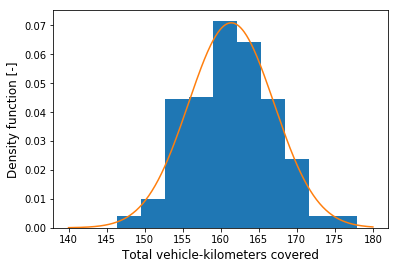

In [105]:
res = np.array(vkm)
print res.mean(), res.std(), res.min(), res.max()

plt.hist(res, density=True)
print plt.xticks()[0]

xt = plt.xticks()[0]
xmin, xmax = min(xt), max(xt)
lnspc = np.linspace(xmin, xmax, len(res))

m, s = stats.norm.fit(res)
plt.plot(lnspc, stats.norm.pdf(lnspc, m, s))

# plt.legend(fontsize=12)
plt.xlabel('Total vehicle-kilometers covered', fontsize=12)
plt.ylabel('Density function [-]', fontsize=12)

plt.savefig('vkm.png', dpi=300)

plt.show()

In [82]:
odms[0]

array([[20, 22,  2,  1,  2,  3,  7,  5],
       [ 5,  6,  1,  1,  3, 20, 18,  7],
       [ 3,  5,  1,  2,  5, 32,  7,  8],
       [ 2,  5,  3, 11, 23,  7,  2,  8],
       [ 2,  5,  3, 18, 20,  5,  2,  7],
       [ 2, 13, 21, 10,  5,  2,  1,  7],
       [ 8, 40,  3,  1,  1,  2,  3,  4]])

In [94]:
mean_odm = np.zeros((7, 8))

for odm in odms:
    for i in range(len(mean_odm)):
        for j in range(len(mean_odm[0])):
            mean_odm[i][j] += odm[i][j]

In [95]:
for i in range(len(mean_odm)):
    for j in range(len(mean_odm[0])):
        mean_odm[i][j] = round(mean_odm[i][j] / len(odms), 2)
mean_odm

array([[22.49, 21.4 ,  2.94,  1.01,  1.39,  2.53,  6.7 ,  5.57],
       [ 6.65,  6.61,  1.91,  1.11,  2.52, 17.28, 19.77,  8.28],
       [ 3.81,  5.47,  2.02,  2.14,  4.69, 28.98,  7.67,  9.3 ],
       [ 2.15,  5.36,  3.36, 11.75, 22.84,  6.07,  2.7 ,  9.9 ],
       [ 2.03,  5.38,  3.61, 19.01, 19.13,  4.34,  2.13,  8.53],
       [ 2.28, 12.23, 24.78,  9.75,  4.74,  1.32,  1.3 ,  7.65],
       [ 9.27, 39.72,  4.25,  1.06,  1.09,  1.22,  2.77,  4.52]])

In [14]:
nnodes, nregions = len(net.nodes), len(net.regions)
nodes = net.nodes
nodes.extend(sorted(net.regions, key=lambda r: r.code))
for nd in nodes[-nregions:]:
    nd.code += nnodes

min_x, max_x = 100, 0
min_y, max_y = 100, 0

for nd in nodes:
    if nd.x < min_x: min_x = nd.x
    if nd.y < min_y: min_y = nd.y
    if nd.x > max_x: max_x = nd.x
    if nd.y > max_y: max_y = nd.y

#print min_x, max_x, min_y, max_y
# normalize coordinates
for nd in nodes:
    nd.x = (nd.x - min_x) / (max_x - min_x)
    nd.y = (nd.y - min_y) / (max_y - min_y)

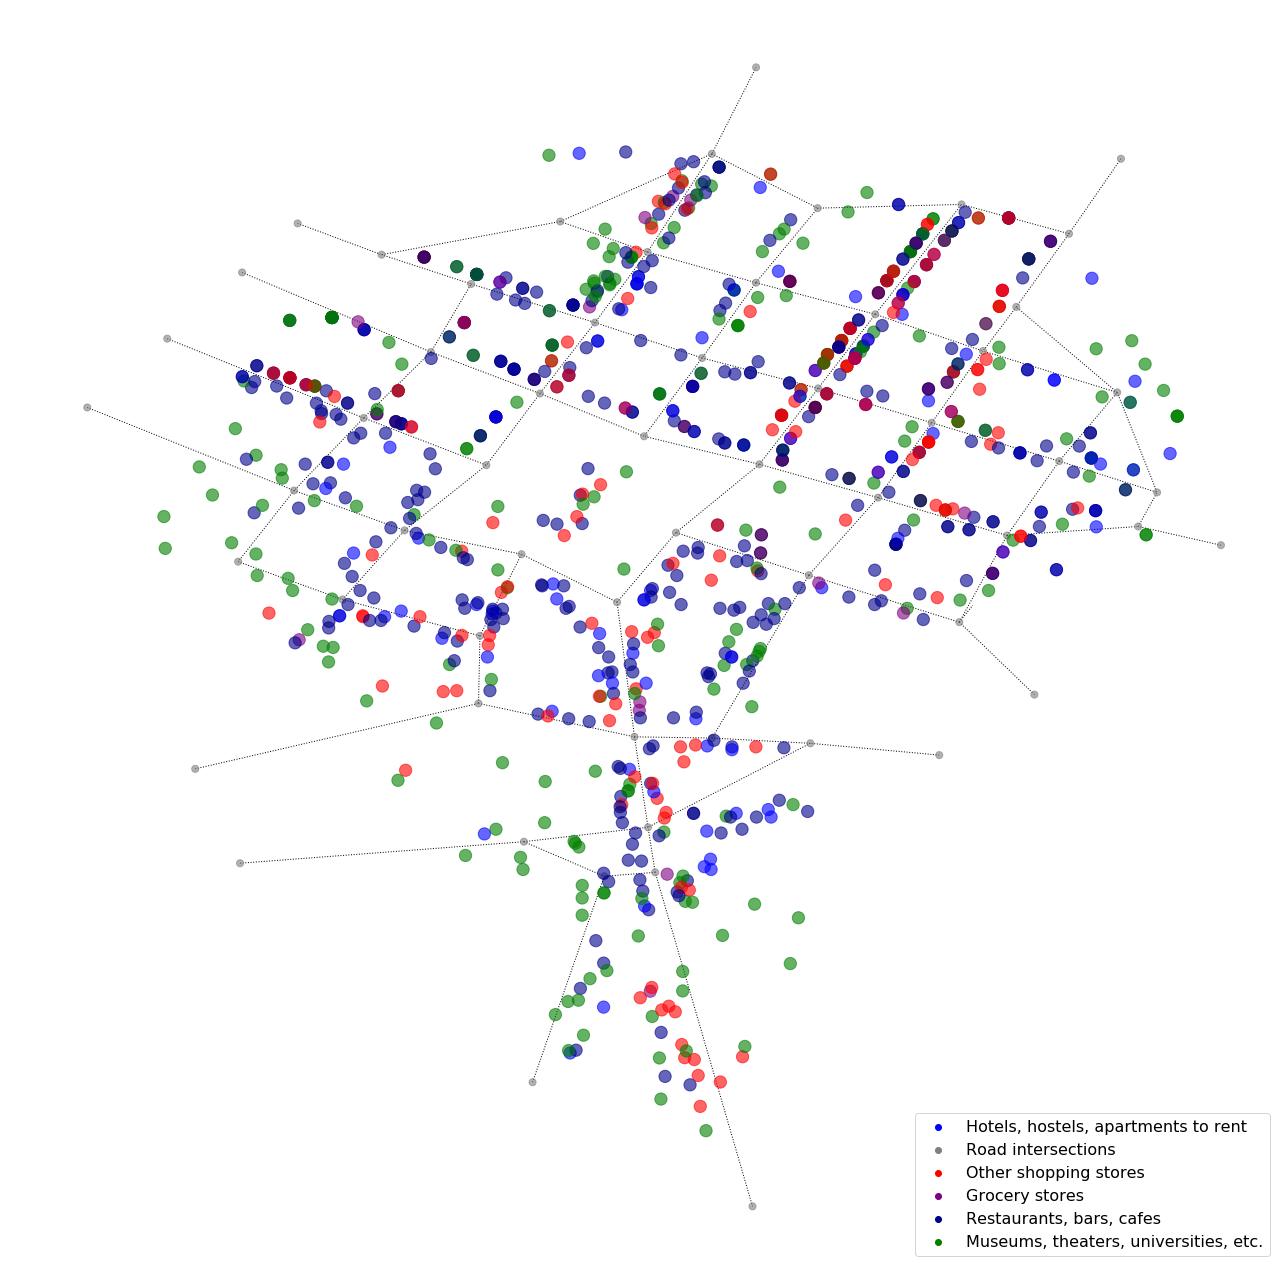

In [15]:
G = nx.Graph()
for nd in nodes[:-nregions]:
    G.add_node(nd.code, pos=(nd.y, nd.x))
for lnk in net.links:
    G.add_edge(lnk.out_node.code, lnk.in_node.code)

pos = nx.get_node_attributes(G, 'pos')
color_map = {
    'R': 'darkblue',
    'H': 'blue',
    'S': 'purple',
    'P': 'red',
    'W': 'green',
    'N': 'grey'
}
node_type_name = {
    'R': 'Restaurants, bars, cafes',
    'H': 'Hotels, hostels, apartments to rent',
    'S': 'Grocery stores',
    'P': 'Other shopping stores',
    'W': 'Museums, theaters, universities, etc.',
    'N': 'Road intersections'
}
colors = [color_map.get(nd.type) for nd in nodes[:-nregions]]

fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot(1, 1, 1)
for label in color_map:
    ax.scatter([], [], color=color_map[label], label=node_type_name[label])

nx.draw_networkx_nodes(G,
                       pos=pos,
                       nodelist=range(59),
                       alpha=0.6,
                       node_color=colors[:60],
                       ax=ax,
                       node_size=50
                      )
nx.draw_networkx_nodes(G,
                       pos=pos,
                       nodelist=range(60, 1013),
                       alpha=0.6,
                       node_color=colors[60:],
                       ax=ax,
                       node_size=150
                      )

nx.draw_networkx_edges(G, 
                       pos=pos,
                       style='dotted')

plt.axis('off')
plt.legend(loc='lower right', fontsize=16)
fig.tight_layout()
plt.savefig("client_map.png", dpi=300)
plt.show()

In [16]:
len(net.nodes), len(colors)

(1022, 1014)

In [17]:
type_map = {'R': 0, 'H': 0, 'S': 0, 'P': 0, 'W': 0, 'N': 0}
for nd in nodes[:-nregions]:
    type_map[nd.type] += 1
type_map

{'H': 108, 'N': 60, 'P': 184, 'R': 380, 'S': 28, 'W': 254}

In [18]:
sum(type_map.values())

1014

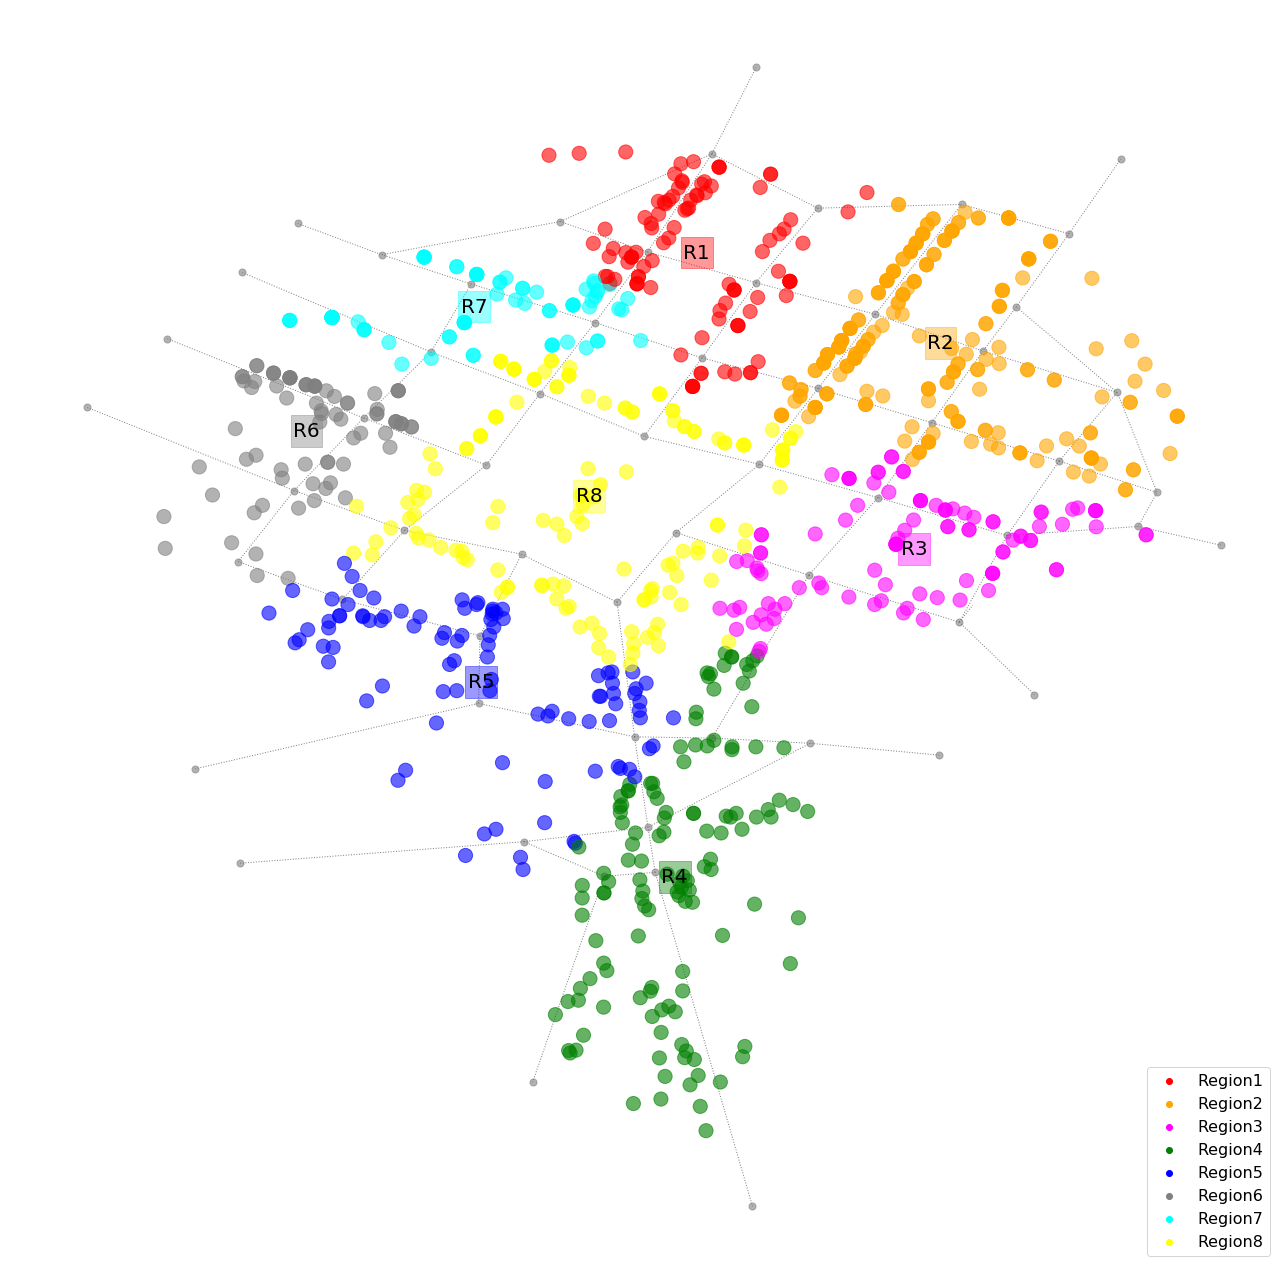

In [19]:
G = nx.Graph()
for nd in nodes:
    G.add_node(nd.code, pos=(nd.y, nd.x)) 
for lnk in net.links:
    G.add_edge(lnk.out_node.code, lnk.in_node.code)

pos = nx.get_node_attributes(G, 'pos')
# print pos

color_map = {
    0: 'red',
    1: 'orange',
    2: 'magenta',
    3: 'green',
    4: 'blue',
    5: 'grey',
    6: 'cyan',
    7: 'yellow'
}
colors = [color_map[nd.region.code - nnodes] for nd in nodes[:-nregions]]
colors.extend([color_map[nd.code - nnodes] for nd in nodes[-nregions:]])

fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot(1, 1, 1)
for label in color_map:
    ax.scatter([], [], color=color_map[label], label=net.get_region(label + nnodes).name)

nx.draw_networkx_nodes(G,
                       pos=pos,
                       nodelist=range(59),
                       alpha=0.6,
                       node_color='grey',
                       node_size=50
                      )
nx.draw_networkx_nodes(G,
                       pos=pos,
                       nodelist=range(60, nnodes),
                       alpha=0.6,
                       node_color=colors[60:],
                       node_size=200
                      )
nx.draw_networkx_nodes(G,
                       pos=pos,
                       nodelist=range(nnodes, nnodes + nregions),
                       node_shape='s',
                       alpha=0.4,
                       node_color=colors[-nregions:],
                       node_size=1000
                      )
nx.draw_networkx_edges(G, 
                       pos=pos,
                       alpha=0.5,
                       style='dotted')

reg_names = {}
for nd in nodes[-nregions:]:
    reg_names[nd.code] = 'R' + str(nd.code - nnodes + 1)
nx.draw_networkx_labels(G, pos, reg_names, font_size=20)


plt.axis('off')
plt.legend(loc='lower right', fontsize=16)
fig.tight_layout()
plt.savefig("regions.png", dpi=300)
plt.show()